In [1]:
#load linear trpo parameters
import jsonpickle
import linear_trpo_utils

learned_parameter_theta_file_name = 'learned_parameter_theta.json'
learned_parameter_theta_dict = jsonpickle.decode(open(learned_parameter_theta_file_name).read())
vix_theta = learned_parameter_theta_dict['learned_parameter_theta']

In [2]:
#parameters for spy
spy_parameters = {}
spy_parameters['inner_denoise_std'] = 2
spy_parameters['outer_denoise_std'] = 2
spy_parameters['buy_1_threshold'] = 1
spy_parameters['buy_2_threshold'] = 2
spy_parameters['sell_1_threshold'] = 1
spy_parameters['sell_2_threshold'] = 2
spy_parameters['inner_window_length_interval'] = 10 #in unit of days
spy_parameters['outer_window_length_interval'] = 25
spy_parameters['buy_1_wait'] = 1 #in unit of days
spy_parameters['buy_2_wait'] = 2
spy_parameters['sell_1_wait'] = 1
spy_parameters['sell_2_wait'] = 1
spy_parameters['min_profit'] = 0.5 #in unit of percentage
spy_parameters['pct_portfolio_in_vix'] = 0.1 #in unit of percentage

#convert the window length from unit of days into interval count
days_into_interval = 1

In [3]:
import trading_vix_and_spy
import numpy as np
import pandas as pd
import trading_vix_and_spy_utils

In [4]:
local_env = trading_vix_and_spy.trading_vix_and_spy()
local_env.seed(1)

In [55]:
move_from_vix_to_spy = []
total_value_in_vix = []
total_value_in_spy = []
total_spy_cash = []
spy_price_history = None
inner_lower_bound_history = []
inner_upper_bound_history = []
outer_lower_bound_history = []
outer_upper_bound_history = []
spy_buy_sell = []
vix_price_history = None
vix_buy_sell = []
spy_new_position_value = []

In [56]:
full_observation = local_env.reset()

#vix observation
vix_observation = np.concatenate((full_observation[0:5],[full_observation[6]]))
vix_observation = np.array([e for e in vix_observation], dtype=np.float32)
vix_current_feature = linear_trpo_utils.extract_features(vix_observation,1) #1 for the output dimension

#spy observation
spy_observation = full_observation[5]
#other things related to spy trading
last_buy_1_time = -99999
last_buy_2_time = -99999
last_sell_1_time = -99999
last_sell_2_time = -99999
min_spy_purchase_price = float('inf')
time_index = 0

while True:
    
    #vix trading action
    vix_action = linear_trpo_utils.compute_action_distribution(vix_theta,vix_current_feature,mode = 'test')
    
    #spy trading action
    inner_lower_bound, inner_upper_bound = trading_vix_and_spy_utils.generate_spy_bounds(
        spy_observation,
        int(spy_parameters['inner_window_length_interval']*days_into_interval),
        spy_parameters['inner_denoise_std'],
        spy_parameters['buy_1_threshold'],
        spy_parameters['sell_1_threshold']
    )

    outer_lower_bound, outer_upper_bound = trading_vix_and_spy_utils.generate_spy_bounds(
        spy_observation,
        int(spy_parameters['outer_window_length_interval']*days_into_interval),
        spy_parameters['outer_denoise_std'],
        spy_parameters['buy_2_threshold'],
        spy_parameters['sell_2_threshold']
    )
    
    current_spy_price = spy_observation[-1]
    
    spy_action = 0.5 #do nothing spy action is 0.5
    spy_action_type = None
    #see if we can buy
    if current_spy_price < inner_lower_bound and current_spy_price > outer_lower_bound:
        time_since_last_buy = (time_index-last_buy_1_time) #time_since_last_buy is in unit of interval
        if time_since_last_buy > spy_parameters['buy_1_wait']*days_into_interval:
            spy_action = 1
            spy_action_type = 'buy_1'
    if current_spy_price < inner_lower_bound and current_spy_price < outer_lower_bound:
        time_since_last_buy = (time_index-last_buy_2_time)
        if time_since_last_buy > spy_parameters['buy_2_wait']*days_into_interval:
            spy_action = 1
            spy_action_type = 'buy_2'
    
    #see if we can sell
    if current_spy_price > inner_upper_bound and current_spy_price < outer_upper_bound:
        time_since_last_sell = (time_index-last_sell_1_time)
        if time_since_last_sell > spy_parameters['sell_1_wait']*days_into_interval:
            if current_spy_price > min_spy_purchase_price*(1+spy_parameters['min_profit']/100):
                spy_action = 0
                spy_action_type = 'sell_1'
            
    if current_spy_price > inner_upper_bound and current_spy_price > outer_upper_bound:
        time_since_last_sell = (time_index-last_sell_2_time)
        if time_since_last_sell > spy_parameters['sell_2_wait']*days_into_interval:
            if current_spy_price > min_spy_purchase_price*(1+spy_parameters['min_profit']/100):
                spy_action = 0
                spy_action_type = 'sell_2'
                
    #form the joint action
    action_df = pd.DataFrame()
    action_df['0'] = [spy_action]
    action_df['1'] = [vix_action[0][0]] 
    action_df['2'] = [spy_parameters['pct_portfolio_in_vix']]
    
    action_array = action_df.iloc[0].tolist()
    action_array = np.reshape(action_array,(-1,))
    
    print('the action_array is',action_array)
    
    full_observation, reward, done, info = local_env.step(action_array)
    
    #prepare for the next round of action
    if info['bought_spy']:
        if spy_action_type == 'buy_1':
            last_buy_1_time = time_index
        if spy_action_type == 'buy_2':
            last_buy_2_time = time_index
    if info['sold_spy']:
        if spy_action_type == 'sell_1':
            last_sell_1_time = time_index
        if spy_action_type == 'sell_2':
            last_sell_2_time = time_index
    min_spy_purchase_price = info['min_spy_purchase_price']
    time_index += 1
    
    #record information for plotting
    move_from_vix_to_spy.append(info['value_add_to_vix'])
    total_value_in_vix.append(info['total_vix_value'])
    total_value_in_spy.append(info['total_spy_value'])
    total_spy_cash.append(info['spy_cash'])
    inner_lower_bound_history.append(inner_lower_bound)
    inner_upper_bound_history.append(inner_upper_bound)
    outer_lower_bound_history.append(outer_lower_bound)
    outer_upper_bound_history.append(outer_upper_bound)
    
    if info['bought_spy']:
        spy_buy_sell.append(1)
    elif info['sold_spy']:
        spy_buy_sell.append(-1)
    else:
        spy_buy_sell.append(0)
        
    if info['bought_vix']:
        vix_buy_sell.append(1)
    elif info['sold_vix']:
        vix_buy_sell.append(-1)
    else:
        vix_buy_sell.append(0)
    
    spy_new_position_value.append(info['spy_new_position_value'])
    
    print('the info is',info)
    print(' ')
    
    if done:
        spy_price_history = info['spy_price_trajectory']
        vix_price_history = info['vix_price_trajectory']
        break
    
    spy_observation = full_observation[5]
    
    vix_observation = np.concatenate((full_observation[0:5],[full_observation[6]]))
    vix_observation = np.array([e for e in vix_observation], dtype=np.float32)
    vix_current_feature = linear_trpo_utils.extract_features(vix_observation,1) #1 for the output dimension
    
    

the action_array is [0.5        1.01414946 0.1       ]
in env and the sell vix value is [-5000.00000000000]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5000.0, 'total_spy_value': 45000.0, 'vix_price_trajectory': [85.199997, 84.639999], 'spy_price_trajectory': [279.678619, 279.861938], 'bought_vix': True, 'sold_vix': False, 'min_spy_purchase_price': inf, 'value_add_to_vix': -5000.0, 'spy_cash': 45000.0, 'spy_new_position_value': 0}
 
the action_array is [ 0.5        -7.91141887  0.1       ]
in env and the sell vix value is [4967.13626644846]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 4996.713626644847, 'total_spy_value': 44970.42263980361, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005], 'bought_vix': False, 'sold_vix': True, 'min_spy_purchase_price': inf, 'value_add_to_vix': -29.57736019638624, 'spy_cash': 44970.42263980361, 'spy_new_position_value': 

in env and the sell vix value is [-5137.87728783666]
the info is {'bought_spy': True, 'sold_spy': False, 'total_vix_value': 5137.877287836658, 'total_spy_value': 46240.895590529915, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216, 283.5849, 281.453369, 280.845673, 283.594574, 282.427521, 277.711029, 277.325256, 276.486145, 277.875061], 'bought_vix': True, 'sold_vix': False, 'min_spy_purchase_price': 276.486145, 'value_add_to_vix': 3.02079960000098, 'spy_cash': 26333.89315052992, 'spy_new_position_value': 9953.50122}
 
the action_array is [0.5        2.26835816 0.1       ]
in env and the sell vix value is [-368.243266643008]
the info is {'bought_spy': False, 'sold

in env and the sell vix value is [0.0]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5430.028311018901, 'total_spy_value': 46398.42319521695, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216, 283.5849, 281.453369, 280.845673, 283.594574, 282.427521, 277.711029, 277.325256, 276.486145, 277.875061, 270.891968, 273.341827, 274.942902, 277.489227, 275.69519, 273.872345, 276.341431, 275.492676, 272.126526, 272.743835, 270.207153], 'bought_vix': False, 'sold_vix': False, 'min_spy_purchase_price': 270.891968, 'value_add_to_v

in env and the sell vix value is [6.51994028544321e-13]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5311.779094847241, 'total_spy_value': 47798.72466162517, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216, 283.5849, 281.453369, 280.845673, 283.594574, 282.427521, 277.711029, 277.325256, 276.486145, 277.875061, 270.891968, 273.341827, 274.942902, 277.489227, 275.69519, 273.872345, 276.341431, 27

in env and the sell vix value is [5149.75240121567]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5317.493660364085, 'total_spy_value': 47857.44294327675, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216, 283.5849, 281.453369, 280.845673, 283.594574, 282.427521, 277.711029, 277.325256, 276.486145, 277.875061, 270.891968, 273

in env and the sell vix value is [4.31526824229423e-12]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5331.107821454999, 'total_spy_value': 47979.97039309499, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216, 283.5849, 281.453369, 280.845673, 283.59457

in env and the sell vix value is [-450.653003473768]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5281.035265513469, 'total_spy_value': 47529.317389621225, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999], 'spy_price_trajectory': [279.678619, 279.861938, 279.17712400000005, 279.726898, 279.967957, 282.485352, 281.858429, 281.684845, 282.996582, 283.440216

in env and the sell vix value is [-7.47668533437553]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5271.485458285257, 'total_spy_value': 47443.3691245673, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997], 'spy_price_trajectory': [279.678619, 279.861938, 279.177124

the action_array is [ 0.5        11.09094994  0.1       ]
in env and the sell vix value is [0.0]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5310.126794185054, 'total_spy_value': 47522.65560668689, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.7

in env and the sell vix value is [6150.13257870076]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 6150.132578700764, 'total_spy_value': 47175.99574942253, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.720001, 70.800003, 73.040001, 71.199997, 71.68

in env and the sell vix value is [4740.34515522629]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 6031.04636599084, 'total_spy_value': 48219.76683274235, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.720001, 70.800003, 73.040001, 71.199997, 71.68,

the action_array is [ 0.5        13.62808809  0.1       ]
in env and the sell vix value is [0.0]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5556.061985938061, 'total_spy_value': 49280.318856, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.720001

in env and the sell vix value is [-182.063937215481]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5434.134312023365, 'total_spy_value': 48907.208808210285, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.720001, 70.800003, 73.040001, 71.199997, 71.

in env and the sell vix value is [0.0]
the info is {'bought_spy': False, 'sold_spy': False, 'total_vix_value': 5761.546485720061, 'total_spy_value': 49145.81192355233, 'vix_price_trajectory': [85.199997, 84.639999, 85.120003, 83.720001, 83.040001, 82.32, 84.279999, 86.0, 83.199997, 84.360001, 84.480003, 87.599998, 87.720001, 83.559998, 88.040001, 102.800003, 100.800003, 100.68, 92.879997, 106.440002, 100.720001, 96.559998, 92.480003, 93.760002, 95.160004, 90.440002, 89.440002, 95.360001, 93.440002, 96.199997, 98.120003, 96.080002, 100.279999, 100.919998, 95.480003, 93.440002, 91.599998, 92.360001, 91.440002, 91.760002, 91.199997, 90.800003, 89.91999799999998, 88.879997, 88.199997, 85.160004, 85.559998, 87.599998, 86.720001, 89.08000200000002, 88.239998, 86.760002, 85.599998, 80.68, 77.68, 77.279999, 77.559998, 79.639999, 79.959999, 77.480003, 76.160004, 74.800003, 74.760002, 75.0, 76.720001, 76.040001, 76.879997, 75.279999, 72.720001, 70.800003, 73.040001, 71.199997, 71.68, 73.480003, 

In [57]:
print(len(move_from_vix_to_spy))
print(len(total_value_in_vix))
print(len(total_value_in_spy))
print(len(total_spy_cash))
print(len(spy_price_history))
print(len(inner_lower_bound_history))
print(len(vix_price_history))
print(len(vix_buy_sell))
print(len(spy_new_position_value))

101
101
101
101
101
101
101
101
101


In [58]:
import matplotlib.pyplot as plt

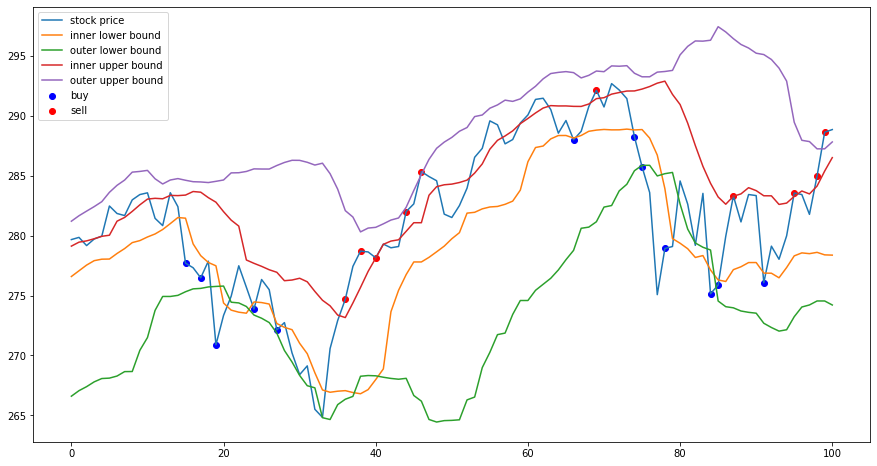

In [59]:
plt.rcParams["figure.figsize"] = (15,8)

already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(spy_price_history,label = 'stock price')
plt.plot(inner_lower_bound_history,label = 'inner lower bound')
plt.plot(outer_lower_bound_history,label = 'outer lower bound')
plt.plot(inner_upper_bound_history,label = 'inner upper bound')
plt.plot(outer_upper_bound_history,label = 'outer upper bound')

for time_index in range(0,len(spy_price_history)):

    if spy_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,spy_price_history[time_index],color = 'b',label = 'buy')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,spy_price_history[time_index],color = 'b')

    elif spy_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,spy_price_history[time_index],color = 'r',label = 'sell')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,spy_price_history[time_index],color = 'r')
            
plt.legend()
plt.show()



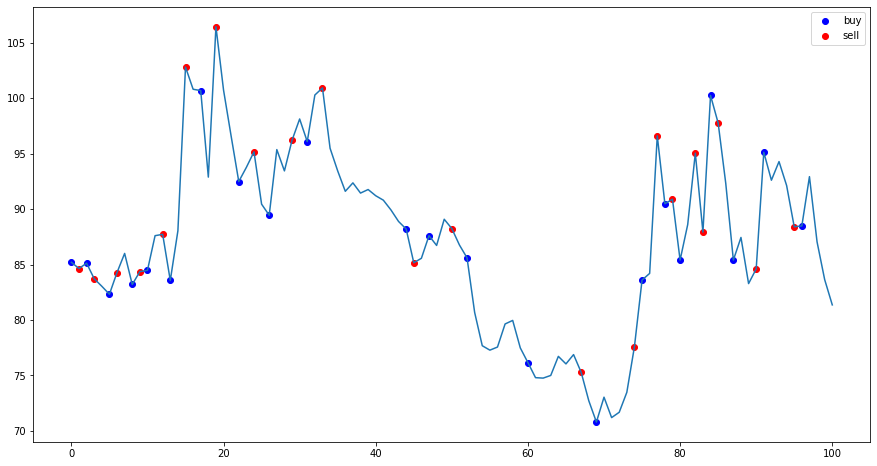

In [60]:


already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(vix_price_history)
for time_index in range(0,len(vix_buy_sell)):

    if vix_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,vix_price_history[time_index],color = 'b',label = 'buy')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,vix_price_history[time_index],color = 'b')

    elif vix_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,vix_price_history[time_index],color = 'r',label = 'sell')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,vix_price_history[time_index],color = 'r')
            
plt.legend()
plt.show()



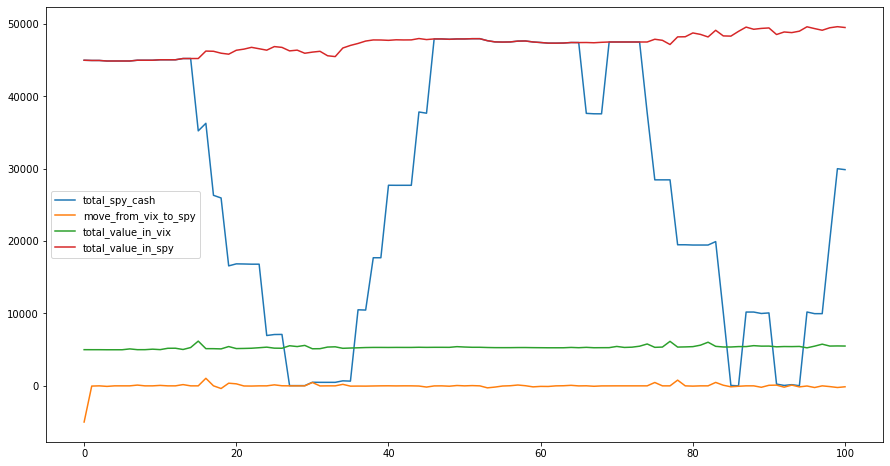

In [61]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(total_spy_cash,label = 'total_spy_cash')
plt.plot(move_from_vix_to_spy,label = 'move_from_vix_to_spy')
plt.plot(total_value_in_vix,label = 'total_value_in_vix')
plt.plot(total_value_in_spy,label = 'total_value_in_spy')
plt.legend()
plt.show()

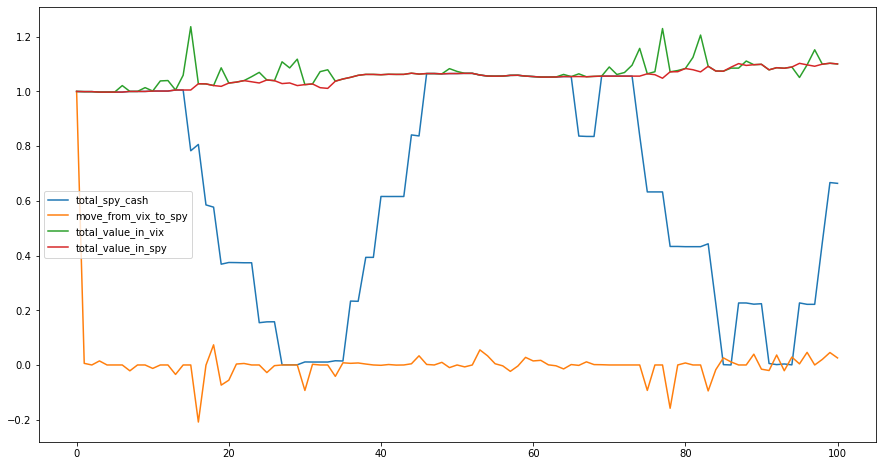

In [62]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(np.asarray(total_spy_cash)/total_spy_cash[0],label = 'total_spy_cash')
plt.plot(np.asarray(move_from_vix_to_spy)/move_from_vix_to_spy[0],label = 'move_from_vix_to_spy')
plt.plot(np.asarray(total_value_in_vix)/total_value_in_vix[0],label = 'total_value_in_vix')
plt.plot(np.asarray(total_value_in_spy)/total_value_in_spy[0],label = 'total_value_in_spy')
plt.legend()
plt.show()

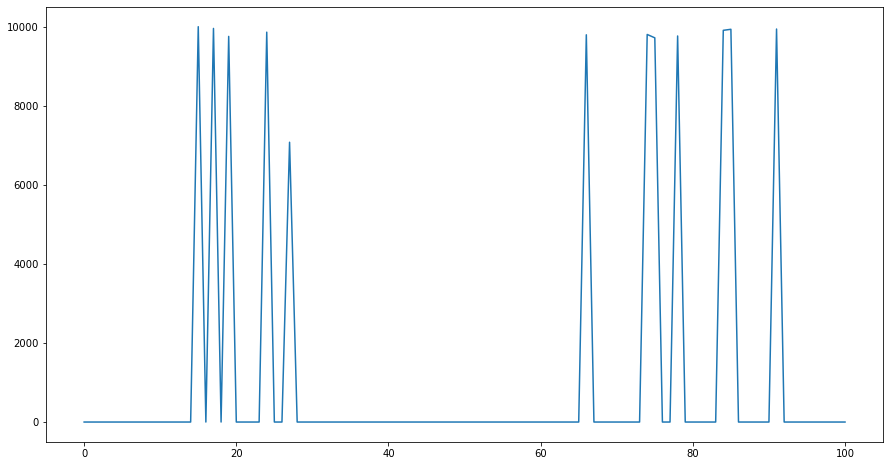

In [63]:
plt.plot(spy_new_position_value)
plt.show()

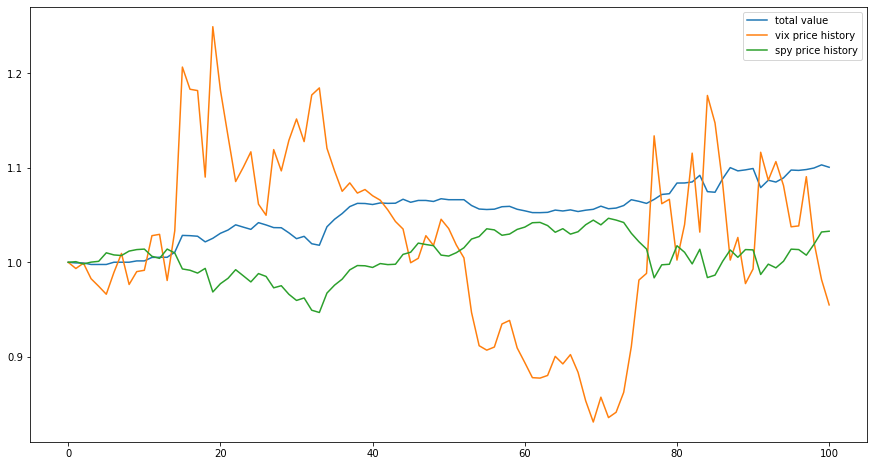

In [64]:
overall_value = np.asarray(total_value_in_vix)+np.asarray(total_value_in_spy)
plt.plot(np.asarray(overall_value)/overall_value[0],label = 'total value')
plt.plot(np.asarray(vix_price_history)/vix_price_history[0],label = 'vix price history')
plt.plot(np.asarray(spy_price_history)/spy_price_history[0],label = 'spy price history')
plt.legend()
plt.show()

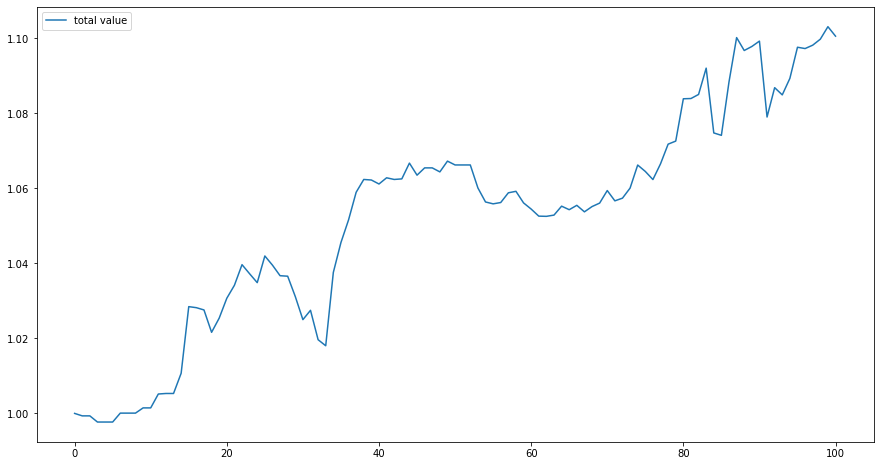

In [65]:
overall_value = np.asarray(total_value_in_vix)+np.asarray(total_value_in_spy)
plt.plot(np.asarray(overall_value)/overall_value[0],label = 'total value')
plt.legend()
plt.show()

In [66]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2f}'.format

df = pd.DataFrame()
df['vix total value'] = total_value_in_vix
df['spy total value'] = total_value_in_spy
df['overall total value'] = np.asarray(total_value_in_vix)+np.asarray(total_value_in_spy)
df['move_from_vix_to_spy'] = move_from_vix_to_spy
df.head(100)

,vix total value,spy total value,overall total value,move_from_vix_to_spy
0,5000.00,45000.00,50000.00,-5000.00
1,4996.71,44970.42,49967.14,-29.58
2,4996.71,44970.42,49967.14,0.00
3,4988.50,44896.46,49884.95,-73.96
4,4988.50,44896.46,49884.95,0.00
5,4988.50,44896.46,49884.95,0.00
6,5107.27,44896.46,50003.73,0.00
7,5000.37,45003.35,50003.73,106.90
8,5000.37,45003.35,50003.73,0.00
9,5070.09,45003.35,50073.44,0.00


In [67]:
pd.reset_option('display.max_rows')

In [68]:
info['total_spy_value']

49524.8929370444

In [69]:
info['total_vix_value']

5502.7658818938235

In [70]:
spy_new_position_value

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9997.597044,
 0,
 9953.50122,
 0,
 9752.110848,
 0,
 0,
 0,
 0,
 9859.404419999999,
 0,
 0,
 7075.289676,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9792.583134,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9801.151609999999,
 9715.804028,
 0,
 0,
 9762.751600000001,
 0,
 0,
 0,
 0,
 0,
 9905.610708,
 9931.780152000001,
 0,
 0,
 0,
 0,
 0,
 9938.757564000001,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [71]:
reward

2308.9811789999994